# practice in Python: System to Classificação of cells Sanguíneas**objective:** Construir one System simplificado that can extrair características of images of cells sanguíneas and use these características to treinar one classificador of aprendizado of máquina capaz of distinguish between different types of cells.**Instruções Gerai:**- Abra this notebook in the Google Colab.- Execute the cells of code in ordem. the projeto is sequencial.- Discuta the perguntas in each section with your grupo.- Modifique the code in the exercises to experimentar and entender the concepts.

## part 0: Configuração and Loading of data**explanation Breve:**Let's begin instalando and importando the libraries necessárias. We will use the dataset `BloodMNIST` of the suíte MedMNIST, that contém images of 8 types different of cells sanguíneas. the code below irá baixar the data and preparar the images and rótulos to uso.**the code Funciona:**1. Instalação: `pip install medmnist` instala the library that facilita the download of the dataset.2. Importações: Importa all the libraries that We will use to the long of the practice.3. Download and Loading:- `BloodMNIST(split='train', download=True)`: low the conjunto of data (if still não estiver presente) and the loads.- Extraímos the images (`images`) and the rótulos (`labels`).- `info['label']`: Contém the mapeamento of the rótulos numéricos (0-7) to the nomes of the classes of cells.4. Visualização: the function `plot_many_images` is defined to display one lote of images of example of different classes.

In [ ]:
# --- 0.1 Instalar the library medmnist --- !pip install -q medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.9 MB/s eta 0:00:00


Baixando e carregando o dataset BloodMNIST...


100%|██████████| 35.5M/35.5M [00:56<00:00, 631kB/s]


Dataset carregado com sucesso!
Mapeamento de Classes: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


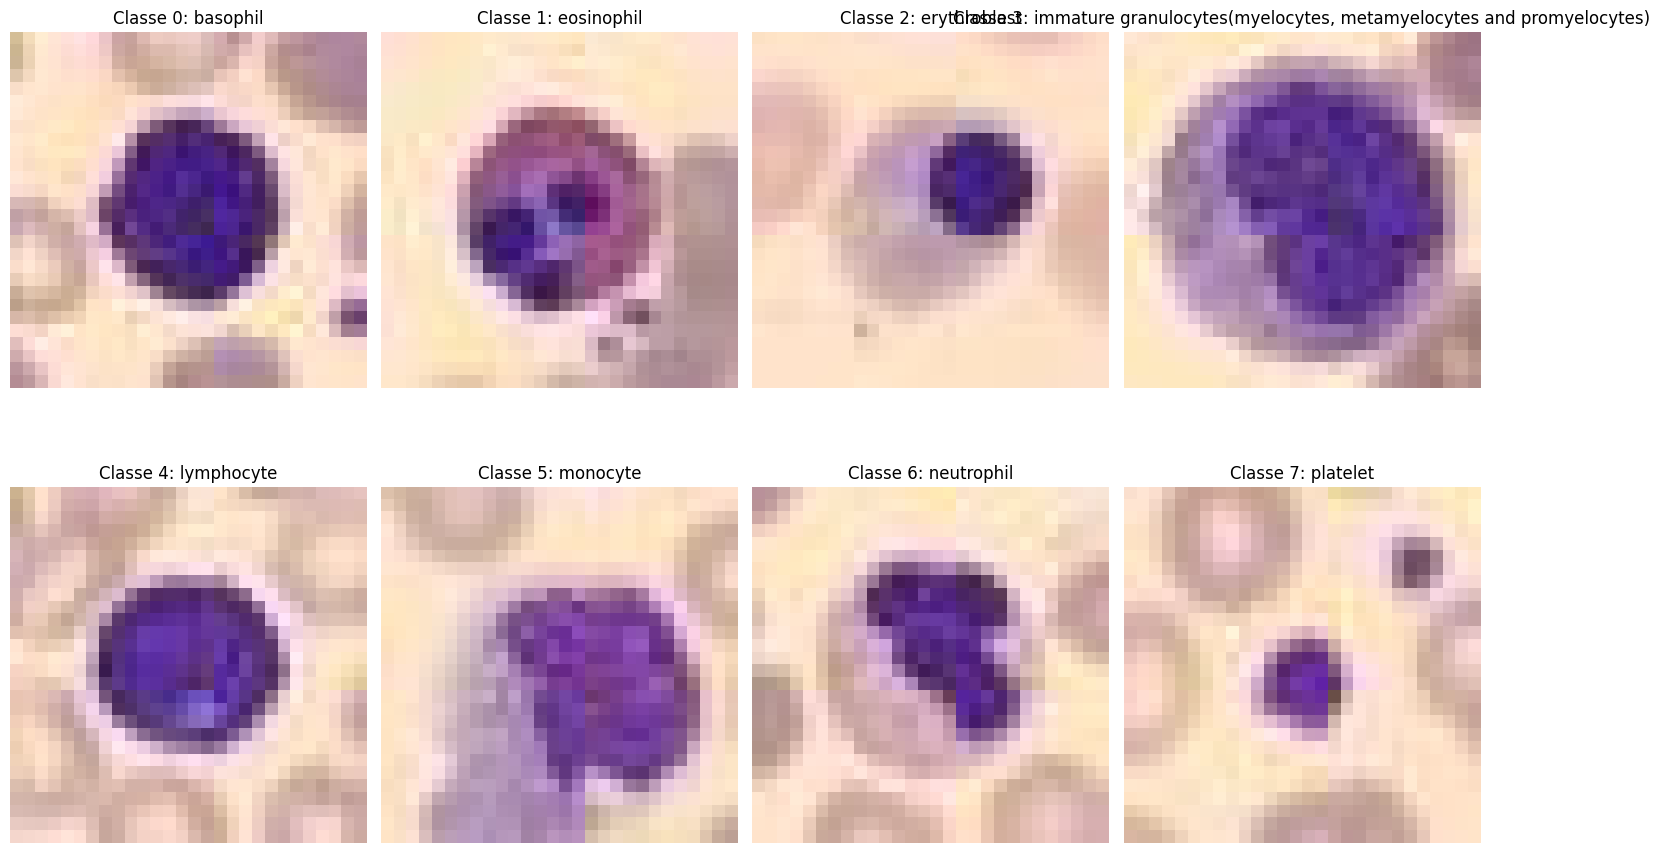

In [ ]:
# --- 0.2 Importações Necessárias --- import numpy as np import matplotlib.pyplot as plt from medmnist import BloodMNIST from skimage import img_as_float, exposure, filters, morphology, measure, color, transform from sklearn.model_selection import train_test_split from skimage.color import rgb2gray, rgb2hsv, hsv2rgb, label2rgb from sklearn.preprocessing import StandardScaler from sklearn.neural_network import MLPClassifier from sklearn.ensemble import RandomForestClassifier from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay import pandas as pd from skimage import util from skimage import data, transform, img_as_float, img_as_ubyte, exposure, filters, morphology, feature from scipy import ndimage import cv2  # --- 0.3 function Auxiliar of Plotagem --- def plot_many_images(images, titles, rows=3, cols=4, figsize=(15,10)):  fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)  axes_flat = axes.ravel()  for i in range(len(axes_flat)):  if i < len(images):  axes_flat[i].imshow(images[i], cmap='gray' if images[i].ndim==2 else None)  axes_flat[i].set_title(titles[i])  axes_flat[i].axis('off')  else:  axes_flat[i].axis('off')  plt.tight_layout()  plt.show()  # --- 0.4 load the Dataset --- print("Baixando e carregando o dataset BloodMNIST...") try:  dataset = BloodMNIST(split='train', download=True)  images = dataset.imgs  labels = dataset.labels.flatten()  class_names = dataset.info['label']  print("Dataset carregado with sucesso!")  print("Mapeamento de Classes:", class_names)   # # show algumas images of example  indices_exemplo = [np.where(labels == i)[0][0] for i in range(len(class_names))]  imagens_exemplo = images[indices_exemplo]  titulos_exemplo = [f"Classe {i}: {class_names[str(i)]}" for i in range(len(class_names))]  plot_many_images(imagens_exemplo, titulos_exemplo, rows=2, cols=4)  except Exception as e:  print(f"Erro ao baixar/carregar o dataset: {e}")  print("A prática não poderá continuar without os dados.")

**Interpretando the results (part 0):**- the cell should baixar the dataset and print the mapeamento of classes (ex: '0': 'basophil', '1': 'eosinophil', etc.).- the grade of 8 images will be exibida, showing an example of each type of cell sanguínea. Observe the differences visuais between they (size, shape, cor of the núcleo, etc.).

## part 1: Fundamentos of the image and Pré-processamento simple**explanation Breve:**all analysis começa with the entendimento of the data. We will analyze the propriedades basic of the images and apply techniques of pré-processamento (realce and redução of noise) to preparar the images to the segmentação.**the code Funciona:**1. analysis of the image: Selecionamos the image of example and verificamos your dimensions, type of data and depth of bits.1. Conversão to Grayscale: We convert the image RGB to Grayscale (`rgb2gray`), because many techniques of segmentação and morfologia operate in images of single channel.1. Realce: Aplicamos `exposure.equalize_hist` to melhorar the contraste of the image in tons of gray.1. Restauração: Simulamos the adição of noise Gaussiano and aplicamos one filters.median to removê-lo, showing the importância of lidar with the noise.

Analisando Imagem 5 - Classe: neutrophil
Dimensões da imagem: (28, 28, 3)
Tipo de dados: uint8
Profundidade de bits (por canal): 8 bits


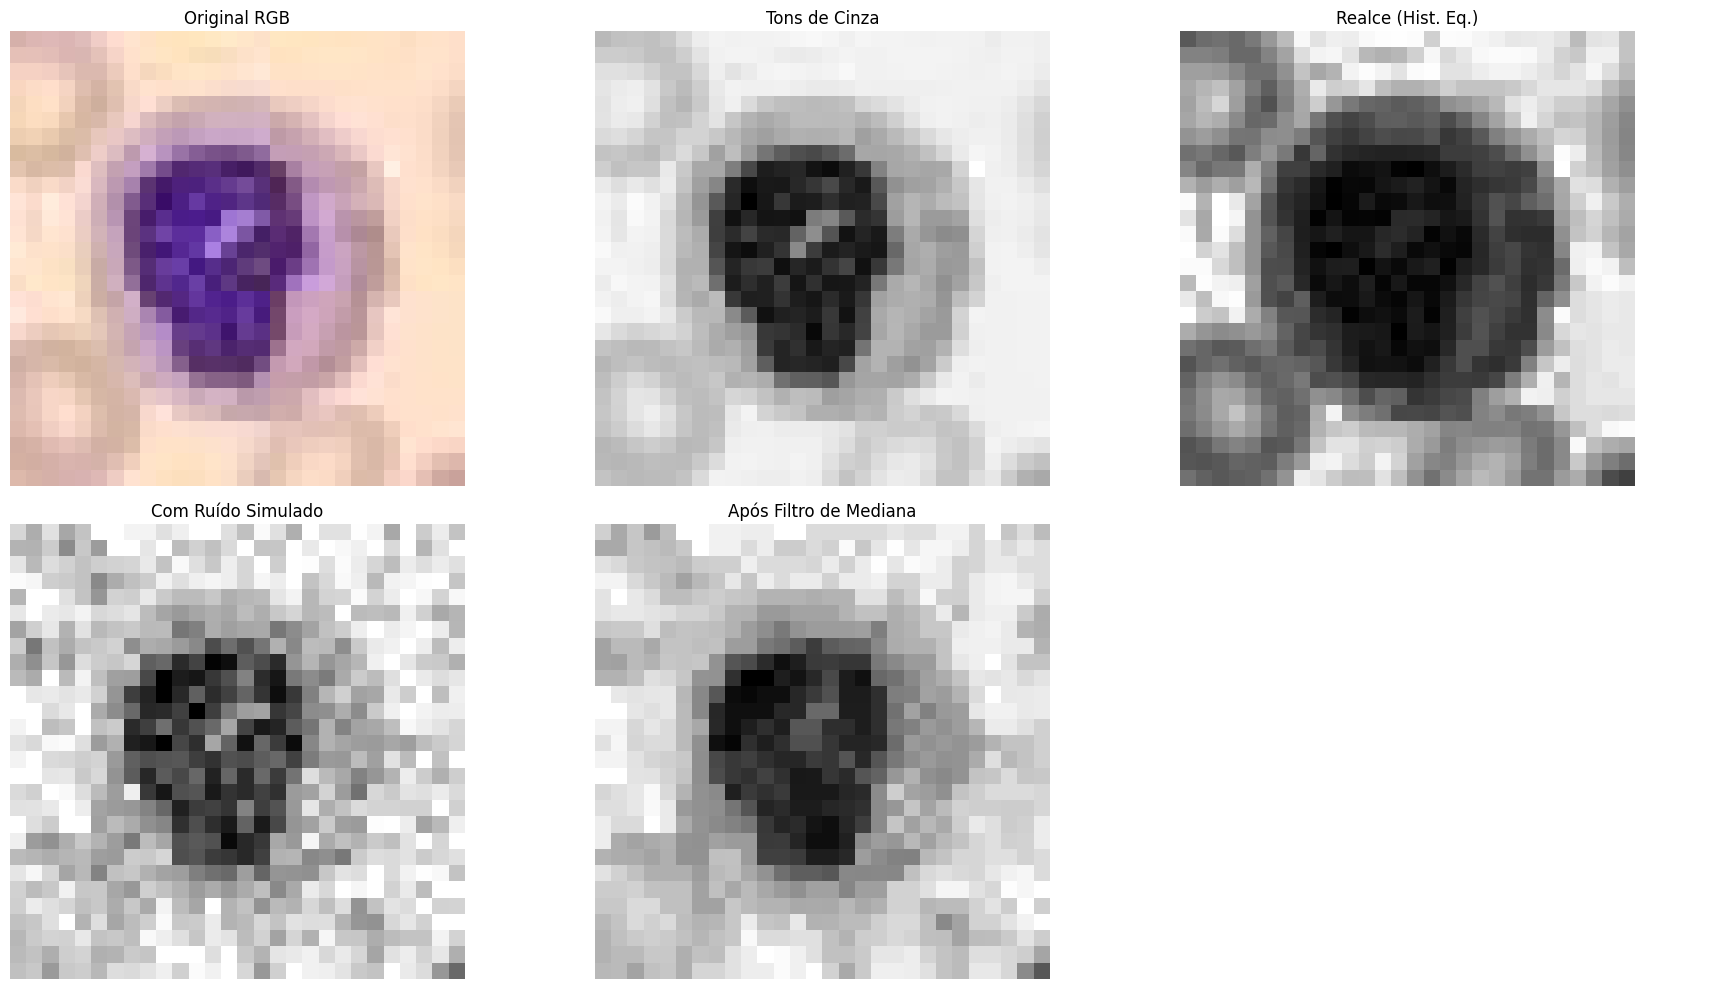

In [ ]:
# --- 1.1 analysis e Pré-processamento basic ---  def plot_many_images(images, titles, rows=1, cols=None, cmaps=None, figsize=(15,10), main_title=None):  """  Plota uma lista de imagens in uma grade.   Args:  images (list): Lista de imagens (arrays NumPy).  titles (list): Lista de títulos to cada imagem.  rows (int): Número de linhas in grade de subplots.  cols (int): Número de colunas in grade. if None, é calculado automaticamente.  cmaps (list or str, optional): Lista de colormaps. if for uma string, é usada to todas.  if None, o padrão of matplotlib é usado.  figsize (tuple): Tamanho of figura.  main_title (str, optional): Título principal to a figura.  """  num_images = len(images)  if cols is None:  # # calculates columns to caberem todas the images  cols = (num_images + rows - 1) // rows   # # squeeze=False garante that 'axes' whether always one array 2D, evitando errors  fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)  axes_flat = axes.ravel() # Achata the array of Axes to facilitar the iteração   # # Lida with the argument cmaps of forma flexível  if cmaps is None:  cmaps_list = [None] * num_images # Deixa the matplotlib decidir the cmap  elif isinstance(cmaps, str):  cmaps_list = [cmaps] * num_images # uses the same cmap to todas  else: # Assume that é the list of cmaps  cmaps_list = list(cmaps)  # # if the list of cmaps for smaller that the number of images, preenche the resto with None  if len(cmaps_list) < num_images:  cmaps_list.extend([None] * (num_images - len(cmaps_list)))   # # Itera about the axes (subplots) e plots the images  for i in range(len(axes_flat)):  ax = axes_flat[i]  if i < num_images:  img = images[i]  title = titles[i]  cmap_val = cmaps_list[i]   # # imshow lida with images coloridas (RGB/RGBA) without cmap.  # # to images 2D (tons of gray), the cmap é applied.  if img.ndim == 2:  ax.imshow(img, cmap=cmap_val)  else:  ax.imshow(img) # to images coloridas, the cmap é ignorado   ax.set_title(title)  ax.axis('off')  else:  ax.axis('off') # Desliga axes extras that não will be usados   if main_title:  fig.suptitle(main_title, fontsize=16)   # # Ajusta the layout to evitar sobreposição of títulos  fig.tight_layout(rect=[0, 0, 1, 0.96] if main_title else None)  plt.show()  # Selecionar the image of example to analysis idx_analise = 5 # Escolha qualquer index of 0 ao size of the dataset img_rgb_exemplo = images[idx_analise] label_exemplo = labels[idx_analise] print(f"Analisando Imagem {idx_analise} - Classe: {class_names[str(label_exemplo)]}")  # Tarefa 1.1: Fundamentos print(f"Dimensões of imagem: {img_rgb_exemplo.shape}") print(f"Tipo de dados: {img_rgb_exemplo.dtype}") print(f"Profundidade de bits (by canal): {img_rgb_exemplo.dtype.itemsize * 8} bits")  # Conversão to Grayscale img_cinza_exemplo = rgb2gray(img_rgb_exemplo)  # Tarefa 1.2: Realce of Contraste img_eq_exemplo = exposure.equalize_hist(img_cinza_exemplo)  # Tarefa 1.3: Redução of noise # add noise to simulation e after remove img_ruidosa_exemplo = util.random_noise(img_cinza_exemplo, mode='gaussian', var=0.01) img_denoised_exemplo = filters.median(img_as_ubyte(img_ruidosa_exemplo), footprint=morphology.disk(1))  # Visualização of the steps plot_many_images(  [img_rgb_exemplo, img_cinza_exemplo, img_eq_exemplo, img_ruidosa_exemplo, img_denoised_exemplo],  ["Original RGB", "Tons de gray", "Realce (Hist. Eq.)", "with Ruído Simulado", "Após Filtro de Mediana"],  rows=2, cols=3, cmaps=[None, 'gray', 'gray', 'gray', 'gray'], figsize=(18,10) )

**Interpretando the results (part 1):**- Tons of gray: the versão in preto and branco of the cell.- Realce (Hist. Eq.): the image with contraste melhorado. the differences between the núcleo and the citoplasma can if tornar more evidentes.- with noise Simulado / after filter of median: shows the noise can degradar the image and the a filter of median can limpá-la efetivamente.**exercise (part 1):**1. Fundamentos: if the images tivessem resolução of 14×14 pixels in vez of 28×28, that impacto This would have in the capacidade of distinguish visually the different types of cells? Discuta the importância of the resolução spatial.2. Realce: in the example, we use equalization of histogram. Try apply the transformação gama (`exposure.adjust_gamma`) to the image `img_cinza_exemplo`. one `γ<1` or `γ>1` would be better to highlight the cell nucleus?3. Restauração: Substitua the `filters.median` by `filters.gaussian`. which of the two filters parece preservar better the edges of the cell while remove the noise? by quê?

## part 2: Segmentação of cells (Cap. 10)**explanation Breve:**the step more crítico is the segmentação, that consiste in isolar the cell of interesse of the fundo of the image. We will use the combinação of techniques: limiarização to create the máscara initial and morfologia mathematical to limpar and refinar this máscara.**the code Funciona:**1. Limiarização of Otsu (Cap. 10.3): `filters.threshold_otsu()` is applied to the image in tons of gray (after one light borramento Gaussiano to reduzir noise) to find one limiar global ótimo that separe the cell (generally more dark) of the fundo. This creates the máscara binary initial.2. Morfologia to Limpeza (Cap. 9):- `remove_small_objects()`: Remove small "noises" brancos that can have been capturados by the limiarização.- `ndi.binary_fill_holes()`: Preenche buracos dentro of the object main (ex: parts more clear of the núcleo that can have been classificadas the fundo).

Segmentando imagem da classe: neutrophil


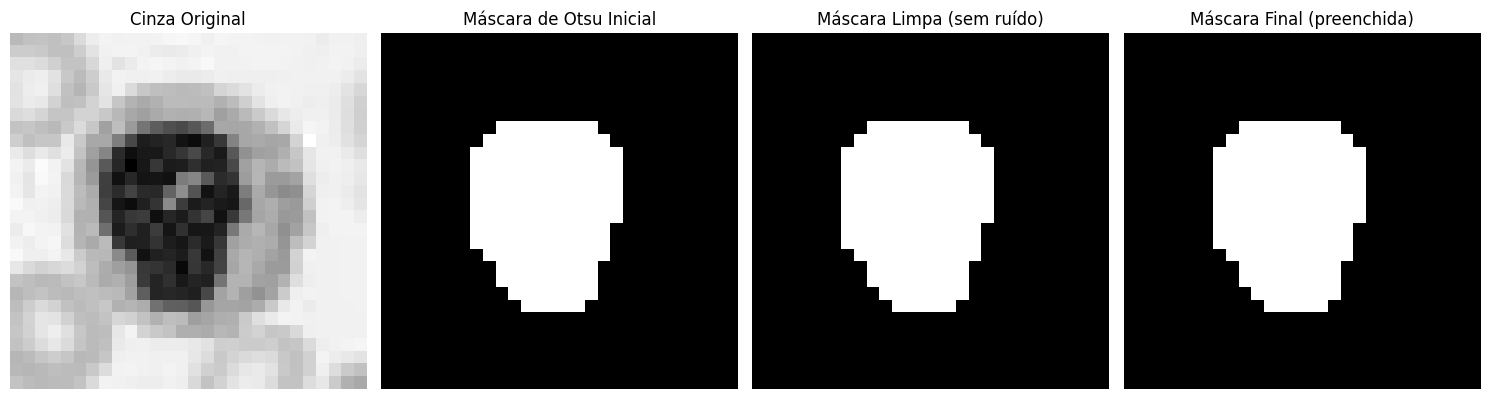

In [ ]:
# --- 2.1 Segmentação of cells (Cap. 10) ---  # We will use the image in tons of gray 'img_cinza_exemplo' print(f"Segmentando imagem of classe: {class_names[str(label_exemplo)]}")  # one light borramento Gaussiano can ajudar the limiarização the be mais robusta img_suavizada_seg = filters.gaussian(img_cinza_exemplo, sigma=1)  # Tarefa 2.1: Limiarização of Otsu (Cap. 10) limiar_otsu_celula = filters.threshold_otsu(img_suavizada_seg) # the cell é mais dark that the fundo, then the máscara é where the image < limiar mascara_inicial = img_suavizada_seg < limiar_otsu_celula  # Tarefa 2.2: Limpeza with Morfologia (Cap. 9) # remove small objects brancos (noise) mascara_limpa = morphology.remove_small_objects(mascara_inicial, 60) # Remove objects with menos of 60 pixels  # Preencher buracos dentro of the object main mascara_final = ndimage.binary_fill_holes(mascara_limpa)  # Visualização of the steps of Segmentação plot_many_images(  [img_cinza_exemplo, mascara_inicial, mascara_limpa, mascara_final],  ["gray Original", "Máscara de Otsu Inicial", "Máscara Limpa (without ruído)", "Máscara Final (preenchida)"],  rows=1, cols=4, cmaps='gray' )

**Interpretando the results (part 2):**- Máscara of Otsu initial: shows the first result of the segmentação. can conter small buracos or objects espúrios.- Máscara Limpa: after remove small objects, the máscara should have less "noise".- Máscara final: the object of the cell should aparecer the mancha branca sólida, pronta to the extração of características.**exercise (part 2):**- Limiarização (Cap. 10): Try use `filters.threshold_local` in vez of threshold_otsu. the segmentação melhora or piora to this image? by quê?- Morfologia (Cap. 9): in the step `morphology.remove_small_objects`, mude the value `60` to `10` and after to `200`. the This afeta the máscara limpa? the that this parameter controla?

## part 3: Extração of Características**explanation Breve:**now that isolamos the cell with the máscara, we can descrevê-la quantitativamente extraindo características (descritores). Let's extrair características of shape, cor and textura.**the code Funciona:**1. `measure.label` and `measure.regionprops`: we use the máscara final to rotular the object (if houvesse more of one). `regionprops` then calculates the série of propriedades to the região rotulada.1. Descritores of Shape: Extraímos area, perimetro, excentricidade (quão alongada is the shape), solidez (quão "sólida" vs. "espinhosa" is the shape), and momentos of Hu (one conjunto of 7 numbers invariantes the translação, scale and rotação that describe the shape).1. Descritores of Cor: we use the máscara to selecionar the pixels correspondentes to the cell in the image RGB original and calculamos the average of each channel of cor (R, G, B).1. Descritores of Textura: we use the máscara in the image in tons of gray to calculate the average and the deviation standard of the intensidade of the pixels of the cell.


--- Características Extraídas da Célula Segmentada ---
  area: 150.0000
  perimetro: 43.5563
  excentricidade: 0.6278
  solidez: 0.9804
  media_R: 108.4133
  media_G: 67.2067
  media_B: 138.1667
  media_intensidade: 0.3180
  std_intensidade: 0.1425
  hu_0: 0.0007
  hu_1: 0.0000
  hu_2: 0.0000
  hu_3: 0.0000
  hu_4: 0.0000
  hu_5: 0.0000
  hu_6: 0.0000


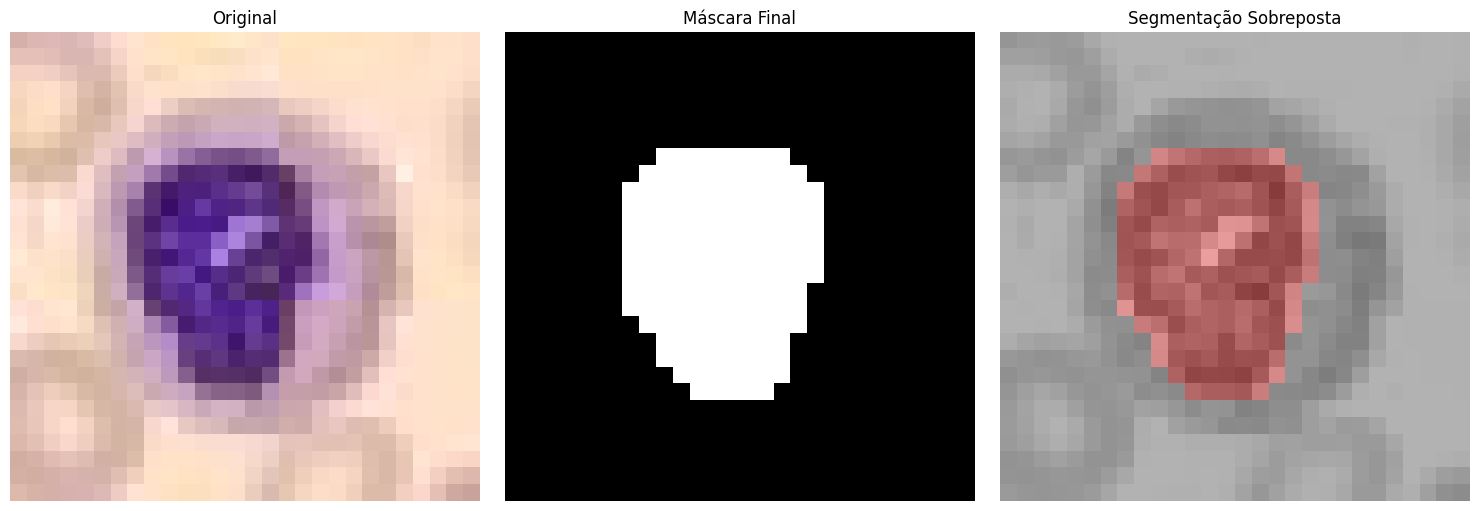

In [ ]:
# --- 3.1 Extração of Características (Cap. 11) ---  # use the mascara_final of the step previous e the original image (RGB e gray)  # Rotular the região in the máscara final to use regionprops labels_celula = measure.label(mascara_final)  # Extrair propriedades of the região (assumindo that há apenas 1 object main) if labels_celula.max() == 0: # if the segmentação falhe e não encontre nenhum object  print("Nenhum objeto encontrado in segmentação. Pulando extração de características.")  features_dict = None else:  propriedades = measure.regionprops(labels_celula, intensity_image=img_cinza_exemplo)  prop_obj_principal = propriedades[0] # Assumir that the larger object é the first/unique   # # --- Descritores of Forma ---  area = prop_obj_principal.area  perimetro = prop_obj_principal.perimeter  excentricidade = prop_obj_principal.eccentricity  solidez = prop_obj_principal.solidity   # # Momentos of Hu (using cv2)  # # the image to momentos precisa be uint8  mascara_ubyte_hu = img_as_ubyte(mascara_final)  momentos_espaciais = cv2.moments(mascara_ubyte_hu)  momentos_hu = cv2.HuMoments(momentos_espaciais).flatten()   # # --- Descritores of Cor ---  pixels_celula_rgb = img_rgb_exemplo[mascara_final]  media_R, media_G, media_B = np.mean(pixels_celula_rgb, axis=0)   # # --- Descritores of Textura ---  pixels_celula_cinza = img_cinza_exemplo[mascara_final]  media_intensidade = np.mean(pixels_celula_cinza)  std_intensidade = np.std(pixels_celula_cinza)   # # Compilar todas the características in one dicionário  features_dict = {  'area': area,  'perimetro': perimetro,  'excentricidade': excentricidade,  'solidez': solidez,  'media_R': media_R,  'media_G': media_G,  'media_B': media_B,  'media_intensidade': media_intensidade,  'std_intensidade': std_intensidade,  }  # # add momentos of Hu  for i, hu_val in enumerate(momentos_hu):  features_dict[f'hu_{i}'] = hu_val   print("\n--- Características Extraídas of Célula Segmentada ---")  for nome, valor in features_dict.items():  print(f" {nome}: {valor:.4f}")  # visualize the segmentação sobreposta to the original image segmentacao_sobreposta = color.label2rgb(labels_celula, image=img_rgb_exemplo, bg_label=0, alpha=0.3) plot_many_images(  [img_rgb_exemplo, mascara_final, segmentacao_sobreposta],  ["Original", "Máscara Final", "Segmentação Sobreposta"],  1, 3, cmaps=[None, 'gray', None], figsize=(15,5) )

**Interpretando the results (part 3):**- the cell impressa shows the values numéricos of the descritores to the cell of example. these numbers are the that the computador "sees".- the visualização of the "Segmentação Sobreposta" ajuda the confirmar if the máscara final really isolou the cell correctly.**exercise (part 3):**1. Descritores (Cap. 11): Olhando the types of cells of the dataset (basófilo, eosinófilo, linfócito, etc.), quais dessas características (área, excentricidade, cor, textura) you acham that would be more useful to diferenciar one "neutrófilo" of one "linfócito"? (can exigir the research fast about the morfologia dessas cells).1. the Transformada of Fourier is mencionada in the chapter 4. the Descritores of Fourier (mencionados in the Cap. 11) could be usados here? the that they descreveriam? (tip: they describe the contorno of the cell in the domínio of the frequency).

## part 4: Classificação of objects**explanation Breve:**now, We will use the características that aprendemos the extrair to treinar one classificador of aprendizado of máquina. the process will be:1. process one subconjunto of images, applying the segmentação and extração of características in each the.1. divide our conjunto of data of características in treino and test.1. Treinar one classificador (We will use the Rede Neural MLP simple) with the data of treino.1. evaluate the desempenho of the classificador in the data of test.**the code Funciona:**1. Loop of Extração of Características:- Itera about one number `num_amostras_total` of images of the dataset.- to each image, applies all the pipeline of segmentação and extração of características that construímos.- Armazena the dicionário of características and the rótulo correspondente in the list.2. creation of the DataFrame: the list of dicionários is convertida to one DataFrame of the Pandas, that is the estrutura of data tabular conveniente.3. Preparação to Treinamento:- `X` contém the características (`features`), `y` contém the rótulos (`labels`).- `train_test_split` divide `X` and `y` in conjuntos of treino and test.- `StandardScaler` normaliza the características. This is very important to the bom funcionamento of redes neurais.4. Treinamento and evaluation:- `MLPClassifier(...)`: defines the arquitetura of the rede neural.- `.fit(X_train, y_train)`: Treina the classificador.- `.predict(X_test)`: does predictions in the conjunto of test.- `accuracy_score` and `confusion_matrix`: evaluate the desempenho of the model.


--- Módulo 4: Classificação de Objetos ---
Extraindo características de 1000 imagens. Isso pode levar um minuto...
Processamento concluído. 974 células foram segmentadas e tiveram suas características extraídas.
Amostra do DataFrame de Características:
    area  perimetro  excentricidade   solidez     media_R     media_G  \
0   77.0  30.485281        0.350068  0.962500  211.285714  174.441558   
1  337.0  73.562446        0.526496  0.933518  112.807122   74.729970   
2  122.0  41.213203        0.773509  0.945736  105.663934   63.959016   
3  193.0  61.355339        0.862548  0.839130  116.606218   71.860104   
4   84.0  30.727922        0.298735  0.988235  134.285714   91.261905   

      media_B  media_intensidade  std_intensidade      hu_0          hu_1  \
0  166.727273           0.712607         0.059661  0.000636  1.724403e-09   
1  147.353116           0.345324         0.123943  0.000648  1.088672e-08   
2  131.401639           0.304643         0.137204  0.000713  9.265963e-08   

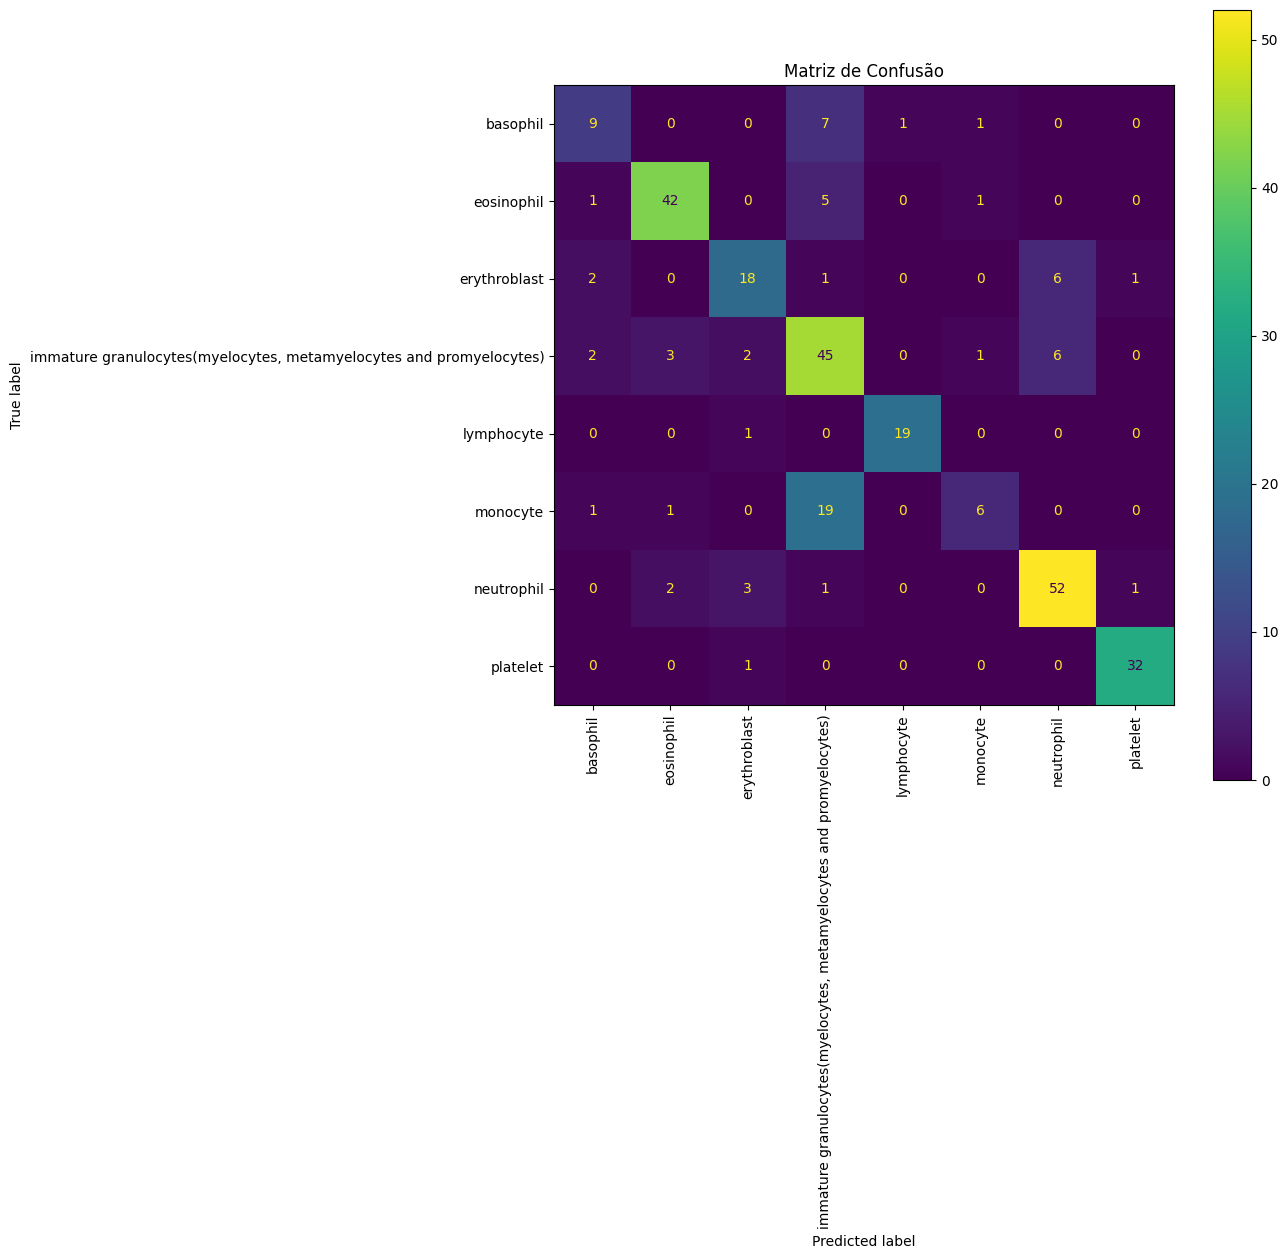

In [ ]:
# --- 4.1 Classificação of objects (Cap. 12) --- print("\n--- Módulo 4: Classificação de Objetos ---")  # function to encapsular the pipeline of segmentação e extração of the image def extrair_features_de_imagem(img_rgb):  try:  # # Pré-processamento e Segmentação  img_cinza = rgb2gray(img_rgb)  img_suavizada = filters.gaussian(img_cinza, sigma=1)  limiar_otsu = filters.threshold_otsu(img_suavizada)  mascara_inicial = img_suavizada < limiar_otsu  mascara_limpa = morphology.remove_small_objects(mascara_inicial, 60)  mascara_final = ndimage.binary_fill_holes(mascara_limpa)   # # Extração of Características  labels = measure.label(mascara_final)  if labels.max() == 0: return None # Falhou in segmentar   # # Achar the larger object if houver mais of one  props = measure.regionprops(labels, intensity_image=img_cinza)  maior_obj_idx = np.argmax([p.area for p in props])  prop_obj_principal = props[maior_obj_idx]   # # Descritores  area = prop_obj_principal.area  perimetro = prop_obj_principal.perimeter  excentricidade = prop_obj_principal.eccentricity  solidez = prop_obj_principal.solidity   mascara_obj_principal = labels == (maior_obj_idx + 1)   pixels_celula_rgb = img_rgb[mascara_obj_principal]  media_R, media_G, media_B = np.mean(pixels_celula_rgb, axis=0) if pixels_celula_rgb.size > 0 else (0,0,0)   pixels_celula_cinza = img_cinza[mascara_obj_principal]  media_intensidade = np.mean(pixels_celula_cinza) if pixels_celula_cinza.size > 0 else 0  std_intensidade = np.std(pixels_celula_cinza) if pixels_celula_cinza.size > 0 else 0   momentos_espaciais = cv2.moments(img_as_ubyte(mascara_obj_principal))  momentos_hu = cv2.HuMoments(momentos_espaciais).flatten()   features_dict = {  'area': area, 'perimetro': perimetro, 'excentricidade': excentricidade,  'solidez': solidez, 'media_R': media_R, 'media_G': media_G,  'media_B': media_B, 'media_intensidade': media_intensidade, 'std_intensidade': std_intensidade,  }  for i, hu_val in enumerate(momentos_hu):  features_dict[f'hu_{i}'] = hu_val   return features_dict   except Exception as e:  # # print(f"error ao process the image: {e}")  return None  # Loop to process one subconjunto of images (ex: 500 to one test fast) num_amostras_total = 1000 # Reduza if estiver demorando muito (ex: 500) all_features = [] all_labels = []  print(f"Extraindo características de {num_amostras_total} imagens. This pode levar um minuto...") for i in range(min(num_amostras_total, len(images))):  img_atual = images[i]  label_atual = labels[i]   features = extrair_features_de_imagem(img_atual)  if features is not None:  all_features.append(features)  all_labels.append(label_atual)  # create one DataFrame of the Pandas df_features = pd.DataFrame(all_features) df_features['label'] = all_labels  print(f"Processamento concluído. {len(df_features)} células were segmentadas e tiveram suas características extraídas.") print("Amostra of DataFrame de Características:") print(df_features.head())  # --- Treinamento e evaluation of the Classificador --- if not df_features.empty:  X = df_features.drop('label', axis=1) # Todas the columns exceto the rótulo  y = df_features['label']   # # divide in treino e test  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)   # # Escalonar características  scaler = StandardScaler()  X_train_scaled = scaler.fit_transform(X_train)  X_test_scaled = scaler.transform(X_test)   # # Treinar one classificador MLP (Rede Neural)  print("\nTreinando Rede Neural (MLPClassifier)...")  mlp = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42, early_stopping=True, n_iter_no_change=20)  mlp.fit(X_train_scaled, y_train)   # # Avaliar in the conjunto of test  y_pred = mlp.predict(X_test_scaled)  acuracia = accuracy_score(y_test, y_pred)  print(f"Acurácia of classificador MLP in conjunto de teste: {acuracia:.4f}")   # # matrix of Confusão  print("Gerando Matriz de Confusão...")  nomes_classes_str = [class_names[str(i)] for i in sorted(y.unique())]  cm = confusion_matrix(y_test, y_pred)  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_classes_str)   fig, ax = plt.subplots(figsize=(10, 10))  disp.plot(ax=ax, xticks_rotation='vertical')  plt.title("Matriz de Confusão")  plt.show() else:  print("Nenhuma característica was extraída, a etapa de classificação was pulada.")

**Interpretando the results (part 4):**- sample of the DataFrame: shows the tabela with the características extraídas to the primeiras cells.- accuracy: one value percentual indicating quantas cells of the conjunto of test were classificadas correctly. the accuracy of 0.85 significa 85% of acerto.matrix of Confusão: the tabela visual that shows the desempenho of the classificador in detalhe.- the diagonal main (of cima to the left to low to the right) shows the classificações corretas.- the values fora of the diagonal are the errors. by example, the cell in the line "basophil" and column "eosinophil" indicates quantos basófilos were incorrectly classificados the eosinófilos.- Ajuda the identify quais classes are more difficult of distinguish to the model.**exercise final and Discussão:**1. accuracy and matrix of Confusão: the accuracy obtida was boa? Olhando the matrix of confusão, quais classes the model teve more dificuldade in distinguish (quais are the larger values fora of the diagonal main)?1. Melhorando the System: the you could melhorar the desempenho of this System? Discutam by the less three ideas, baseadas in the concepts of all the chapters vistos. (Ex: use more características (Cap. 11), use one model of segmentação more robusto (Cap. 10), use one classificador different or with arquitetura different (Cap. 12), use more data of treinamento, etc.).1. Implicações Éticas: Discutam the implicações, desafios and responsabilidades éticas of if construir and implantar one System of diagnóstico auxiliado by computador the this in one ambiente clínico real. the that aconteceria if the System classificasse erroneamente the cell maligna the benigna, or vice-versa?